### Improring the libraries

In [1]:
import COVID19Py
covid19 = COVID19Py.COVID19()

import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline

### Importing the data

In [2]:
country_code = "NL"
location = covid19.getLocationByCountryCode(country_code, timelines=True)

In [3]:
location[0].keys()

dict_keys(['id', 'timelines', 'province', 'last_updated', 'country_population', 'country', 'latest', 'coordinates', 'country_code'])

In [4]:
for i in location:
    print(i.get('province'))

Aruba
Curacao
Sint Maarten

Bonaire, Sint Eustatius and Saba


In [5]:
for i in location:
    province = i.get('province')
    if province == '':
        country=i.get('country')
        
        confirmed_data=i.get('timelines').get('confirmed').get('timeline')
        
        deaths_data=i.get('timelines').get('deaths').get('timeline')
              
        dates=[i for i in sorted(confirmed_data)]
        date_current=dates[-1][:10]

        confirmed=[confirmed_data.get(i) for i in sorted(confirmed_data)]
        deaths=[deaths_data.get(i) for i in sorted(deaths_data)]

        confirmed_daily=np.diff(confirmed)
        
        date_start = datetime.strptime(dates[0], '%Y-%m-%dT%H:%M:%SZ')
        
        date_array=np.array([datetime.strftime(date_start+timedelta(days=i), '%d %b %Y' ) for i in range(len(dates)+100)])  

In [6]:
date_current

'2020-04-03'

### Plotting the raw data

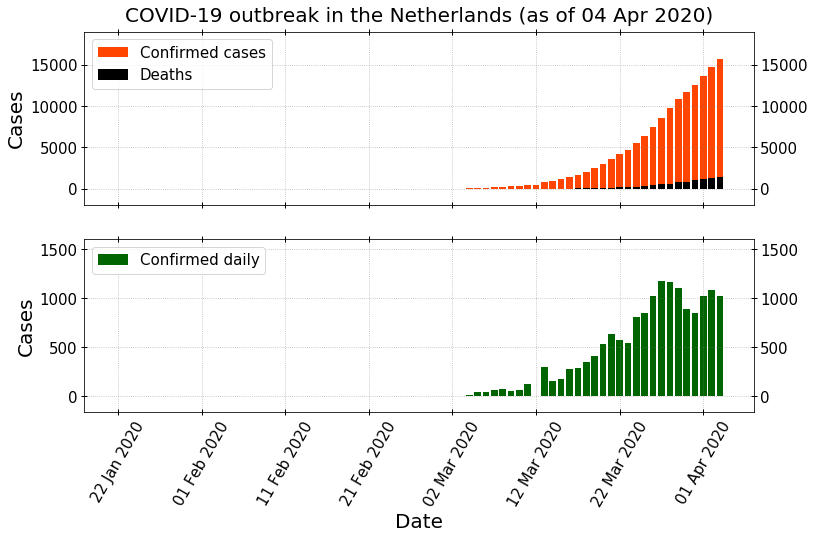

In [7]:
xArray=np.arange(len(confirmed))


fig, axes = plt.subplots(2, sharex=True, sharey=False)   
fig.set_size_inches(12, 7)

axes[0].bar(xArray,confirmed, color='orangered', zorder=1,  label='Confirmed cases') 
axes[0].bar(xArray,deaths, color='black',zorder=2,  label = 'Deaths') 

axes[0].set_ylim(-20*(np.ceil(1.2*max(confirmed)/200)),200*(np.ceil(1.2*max(confirmed)/200)))
axes[0].set_title('COVID-19 outbreak in the ' + country + ' (as of '+date_array[len(dates)]+')', fontsize=20, pad=10)

axes[1].bar(xArray[1:],confirmed_daily, color='darkgreen', label='Confirmed daily')

for axis in axes:
    axis.tick_params(axis='x', direction='inout', length=6, width=1,
             top=True, labeltop=False, labelsize=15)
    axis.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
            top=True, labelright=True, labelsize=15)
    axis.yaxis.set_ticks_position('both')
    axis.grid(True,which="major",ls=":",c='gray', alpha=0.6)
    axis.set_ylabel('Cases', fontsize=20)
    axis.legend(loc=2, fontsize=15)
    
locs = axes[1].get_xticks()
new_locs=[date_array[int(i)] for i in locs]
axes[1].set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60)    

axes[1].set_ylim(-20*(np.ceil(1.2*max(confirmed_daily)/200)),200*(np.ceil(1.2*max(confirmed_daily)/200)))
axes[1].set_xlabel('Date', fontsize=20)

plt.savefig(country+'_data_'+date_current+'.png', dpi=200, bbox_inches="tight")

### Modeling using a logistic function

In [8]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [9]:
import sklearn.metrics as sklm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

c_pars = {}
x=np.arange(len(confirmed))
y=confirmed

y0 = y[0]
yf = y[-1]

print('>>>')
print('>>> Logistic Model')
fit_i = curve_fit(logistic_model,x,y,p0=[3,70,100], maxfev=10000)
ai,bi,ci = fit_i[0]
sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))

print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),(ai,bi,ci))])
print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('sigma_a','sigma_b','sigma_c'),(sigma_ai,sigma_bi,sigma_ci))])

y_pred = logistic_model(x,ai,bi,ci)
MSLE=sklm.mean_squared_log_error(y,y_pred)
print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
print("Exp of RMSLE: ", '{:.3f}'.format(np.exp(np.sqrt(MSLE))))
print("R2 score: ", '{:.3f}'.format(sklm.r2_score(y,y_pred)))

perc_flat = 0.98
sol = int(fsolve(lambda x : logistic_model(x,ai,bi,ci) - perc_flat*int(ci), bi))
print('Day of flattening of the infection curve')
datesol = datetime.strftime(date_start+timedelta(days=sol), '%d %b %Y' )
print('-->'+datesol)

>>>
>>> Logistic Model
['a=4.838', 'b=66.774', 'c=20856.713']
['sigma_a=0.044', 'sigma_b=0.119', 'sigma_c=224.179']
Mean squared log error (MSLE):  1.509
Exp of RMSLE:  3.416
R2 score:  1.000
Day of flattening of the infection curve
-->16 Apr 2020


In [10]:
flatasymp=sol+15
mean = [logistic_model(i,ai,bi,ci) for i in np.arange(flatasymp)]
upper_lim = [logistic_model(i,ai+0,bi+0,ci+3*sigma_ci) for i in np.arange(flatasymp)]
lower_lim = [logistic_model(i,ai-0,bi-0,ci-3*sigma_ci) for i in np.arange(flatasymp)]

### Visualising the original data and the model

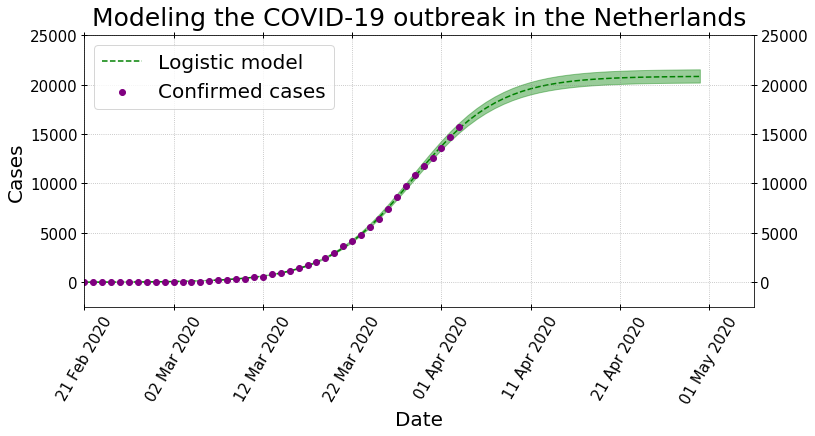

In [11]:
xArr_model=np.arange(len(mean))

fig, ax = plt.subplots(1)   
fig.set_size_inches(12, 5)

ax.scatter(xArray,confirmed, color='purple', zorder=2,  label='Confirmed cases') 

ax.tick_params(axis='x', direction='inout', length=6, width=1,
         top=True, labeltop=False, labelsize=15)
ax.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
        top=True, labelright=True, labelsize=15)
ax.yaxis.set_ticks_position('both')
ax.grid(True,which="major",ls=":",c='gray', alpha=0.6)

ax.plot(xArr_model, mean, 'g--', zorder=1, label = 'Logistic model')

ax.fill_between(xArr_model, upper_lim, lower_lim, color='green', alpha=0.4, zorder=1)

ax.set_ylim(-20*(np.ceil(1.2*max(mean)/200)),200*(np.ceil(1.2*max(mean)/200)))

ax.set_xlim(30,105)
locs = ax.get_xticks()
new_locs=[date_array[int(i)] for i in locs]
ax.set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60) 

ax.legend(loc=2, fontsize=20)

ax.set_ylabel('Cases', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

ax.set_title('Modeling the COVID-19 outbreak in the ' + country, fontsize=25, pad=10)

plt.savefig(country+'_model_'+date_current+'.png', dpi=200, bbox_inches="tight")

In [12]:
mean_diff=np.diff(mean)

upper_lim = [logistic_model(i,ai+3*sigma_ai,bi+3*sigma_bi,ci+3*sigma_ci) for i in np.arange(len(mean))]
lower_lim = [logistic_model(i,ai-3*sigma_ai,bi-3*sigma_bi,ci-3*sigma_ci) for i in np.arange(len(mean))]

upper_lim_diff = np.diff(upper_lim)
lower_lim_diff = np.diff(lower_lim)

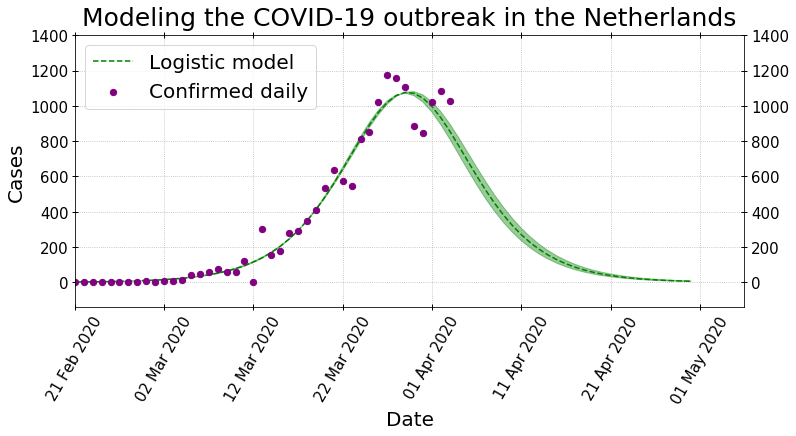

In [13]:
fig, ax = plt.subplots(1)   
fig.set_size_inches(12, 5)

ax.scatter(xArray[1:],confirmed_daily, s=40, color='purple', zorder=2,  label='Confirmed daily')


ax.tick_params(axis='x', direction='inout', length=6, width=1,
         top=True, labeltop=False, labelsize=15)
ax.tick_params(axis='y', which='both', direction='inout', length=6, width=1,
        top=True, labelright=True, labelsize=15)
ax.yaxis.set_ticks_position('both')
ax.grid(True,which="major",ls=":",c='gray', alpha=0.6)

ax.plot(xArr_model[1:], mean_diff, 'g--', zorder=1, label = 'Logistic model')
ax.fill_between(xArr_model[1:], upper_lim_diff, lower_lim_diff, color='g', alpha=0.4)

ax.set_ylim(-20*(np.ceil(1.2*max(mean_diff)/200)),200*(np.ceil(1.2*max(mean_diff)/200)))

ax.set_xlim(30,105)
locs = ax.get_xticks()
new_locs=[date_array[int(i)] for i in locs]
ax.set_xticklabels([i for i in new_locs], fontsize = 15, rotation = 60) 

ax.legend(loc=2, fontsize=20)

ax.set_ylabel('Cases', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

ax.set_title('Modeling the COVID-19 outbreak in the ' + country, fontsize=25, pad=10)

plt.savefig(country+'_model_'+date_current+'.png', dpi=200, bbox_inches="tight")